## Per User/Session, what is the distribution of interclick times? Moreover, can we model the behavior of the user as a poisson process?

In [1]:
# imports
import pandas as pd
import pyexasol

pd.set_option("display.max_colwidth", None)
def printQuery(query, connection):
    stmt = connection.export_to_pandas(query)
    print(stmt.head())
    return stmt

host = '192.168.56.101/3D518979E1BE8B4E0A23B7A296E6AD35D5EC29DCCE01E5CC6ECBA7C9E38D8E96:8563'  # Don't forget to change the fingerprint
user = 'sys'
password = 'exasol'

# Connect to Exasol
conn = pyexasol.connect(dsn=host, 
                        user=user, 
                        password=password, 
                        debug=False, 
                        protocol_version=pyexasol.PROTOCOL_V1)

In [2]:
# Get top 20 url queries, user, and time data
# Interarrival time table with properly formatted date/time
q =  '''
CREATE TABLE AOL_SCHEMA.INTERARRIVAL_TIMES AS
    SELECT 
        FACTS.ANONID,
        CAST(
        CONCAT(
            '2006-',
            LPAD(CASE 
                WHEN TIMEDIM.[day of the year] BETWEEN 60 AND 90 THEN '03'
                WHEN TIMEDIM.[day of the year] BETWEEN 91 AND 120 THEN '04'
                WHEN TIMEDIM.[day of the year] BETWEEN 121 AND 151 THEN '05'
                ELSE '01'
            END, 2, '0'), '-', 
            LPAD(TIMEDIM.[day of the month], 2, '0'), ' ',
            LPAD(TIMEDIM.[hour], 2, '0'), ':', 
            LPAD(TIMEDIM.[minute], 2, '0'), ':', 
            LPAD(TIMEDIM.[second], 2, '0')
        ) AS TIMESTAMP) AS time_as_datetime
    FROM
        AOL_SCHEMA.FACTS LEFT JOIN AOL_SCHEMA.TIMEDIM ON FACTS.TIMEID = TIMEDIM.ID
        LEFT JOIN AOL_SCHEMA.URLDIM ON FACTS.URLID = URLDIM.ID
    WHERE FACTS.CLICK = 1
        AND URLDIM.URL IN (
            SELECT URLDIM.URL
            FROM AOL_SCHEMA.FACTS 
            JOIN AOL_SCHEMA.URLDIM ON AOL_SCHEMA.FACTS.URLID = AOL_SCHEMA.URLDIM.ID
            WHERE AOL_SCHEMA.FACTS.CLICK = 1
            GROUP BY URLDIM.URL
            ORDER BY COUNT(AOL_SCHEMA.FACTS.CLICK) DESC
            LIMIT 20
        )
        AND FACTS.ANONID IS NOT NULL
        AND TIMEDIM.[hour] IS NOT NULL
        AND TIMEDIM.[minute] IS NOT NULL
        AND TIMEDIM.[second] IS NOT NULL
        AND TIMEDIM.[day of the year] IS NOT NULL
'''
conn.execute("DROP TABLE AOL_SCHEMA.INTERARRIVAL_TIMES")
conn.execute(q)




#df = printQuery(q, conn)


<ExaStatement session_id=1815975957734072449 stmt_idx=2>

#### Query weather data table to find date ranges of weather events

In [ ]:

# Top 10 most frequent events
q = '''
SELECT T.EVENT_TYPE, SUM(T.EVENT_ID) AS COUNT
FROM AOL_SCHEMA.WEATHER_EVENTS T 
GROUP BY T.EVENT_TYPE
ORDER BY COUNT DESC
LIMIT 10
'''



# T.EVENT_TYPE = Tornado

printQuery(q, conn)

          EVENT_TYPE        COUNT
0               Hail  54162678808
1  Thunderstorm Wind  26654957873
2          High Wind   8229388280
3            Drought   6667029189
4       Winter Storm   6026282761


,EVENT_TYPE,COUNT
0,Hail,54162678808
1,Thunderstorm Wind,26654957873
2,High Wind,8229388280
3,Drought,6667029189
4,Winter Storm,6026282761
5,Heavy Snow,5486928614
6,Strong Wind,4053520467
7,Tornado,3877637724
8,Winter Weather,3554173834
9,Flash Flood,3295677361


#### Sessions during natural disaster

In [ ]:
# Obtain the anon ID's and times where there are more than 100 instances of clicking on a webpage in the top 20 most clicked webpages and the 

# The anonIDs, interclick times, and session info for those sessions occuring during a tornado
q = '''
SELECT 
    T1.ANONID,
    T1.TIME_AS_DATETIME,
    COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME) AS LaggedDateTime,
    SECONDS_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Seconds_Difference,
    MINUTES_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Minutes_Difference
FROM 
    AOL_SCHEMA.INTERARRIVAL_TIMES as T1
WHERE 
    T1.ANONID IN (
        SELECT T2.ANONID
        FROM AOL_SCHEMA.INTERARRIVAL_TIMES as T2
        GROUP BY T2.ANONID
        HAVING COUNT(T2.ANONID) >= 10
    ) 
    AND EXISTS(
        SELECT 1
        FROM AOL_SCHEMA.WEATHER_EVENTS as T3 
        WHERE 
            (T1.TIME_AS_DATETIME BETWEEN T3.BEGIN_DATE_TIME AND T3.END_DATE_TIME)
            AND (T3.EVENT_TYPE = 'Tornado')
    )
ORDER BY
    T1.ANONID,
    T1.TIME_AS_DATETIME
'''

df_during_disaster = printQuery(q, conn)


   ANONID            TIME_AS_DATETIME              LAGGEDDATETIME  \
0      25  2006-04-02 20:15:56.000000  2006-04-02 20:15:56.000000   
1      25  2006-04-15 15:55:54.000000  2006-04-02 20:15:56.000000   
2      25  2006-04-15 17:30:44.000000  2006-04-15 15:55:54.000000   
3      29  2006-03-12 19:47:08.000000  2006-03-12 19:47:08.000000   
4      29  2006-03-12 21:54:36.000000  2006-03-12 19:47:08.000000   

   SECONDS_DIFFERENCE  MINUTES_DIFFERENCE  
0                   0            0.000000  
1             1107598        18459.966667  
2                5690           94.833333  
3                   0            0.000000  
4                7648          127.466667  


In [60]:
print(df_during_disaster.shape)
df_during_disaster

(28517, 5)


,ANONID,TIME_AS_DATETIME,LAGGEDDATETIME,SECONDS_DIFFERENCE,MINUTES_DIFFERENCE
0,25,2006-04-02 20:15:56.000000,2006-04-02 20:15:56.000000,0,0.000000
1,25,2006-04-15 15:55:54.000000,2006-04-02 20:15:56.000000,1107598,18459.966667
2,25,2006-04-15 17:30:44.000000,2006-04-15 15:55:54.000000,5690,94.833333
3,29,2006-03-12 19:47:08.000000,2006-03-12 19:47:08.000000,0,0.000000
4,29,2006-03-12 21:54:36.000000,2006-03-12 19:47:08.000000,7648,127.466667
...,...,...,...,...,...
28512,657282,2006-04-16 13:35:13.000000,2006-04-16 13:35:13.000000,0,0.000000
28513,657283,2006-04-02 16:37:24.000000,2006-04-02 16:37:24.000000,0,0.000000
28514,657283,2006-04-02 19:10:12.000000,2006-04-02 16:37:24.000000,9168,152.800000
28515,657283,2006-04-02 19:10:12.000000,2006-04-02 19:10:12.000000,0,0.000000


#### Sessions not during natural disaster

In [61]:
# The anonIDs, interclick times, and session info for those sessions occuring during a tornado
q = '''
SELECT 
    T1.ANONID,
    T1.TIME_AS_DATETIME,
    COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME) AS LaggedDateTime,
    SECONDS_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Seconds_Difference,
    MINUTES_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Minutes_Difference
FROM 
    AOL_SCHEMA.INTERARRIVAL_TIMES as T1
WHERE 
    T1.ANONID IN (
        SELECT T2.ANONID
        FROM AOL_SCHEMA.INTERARRIVAL_TIMES as T2
        GROUP BY T2.ANONID
        HAVING COUNT(T2.ANONID) >= 10
    ) 
    AND NOT EXISTS(
        SELECT 1
        FROM AOL_SCHEMA.WEATHER_EVENTS as T3 
        WHERE 
            (T1.TIME_AS_DATETIME BETWEEN T3.BEGIN_DATE_TIME AND T3.END_DATE_TIME)
            AND (T3.EVENT_TYPE = 'Tornado')
    )
ORDER BY
    T1.ANONID,
    T1.TIME_AS_DATETIME
'''

df_not_during_disaster = printQuery(q, conn)

   ANONID            TIME_AS_DATETIME              LAGGEDDATETIME  \
0      15  2006-03-11 09:55:17.000000  2006-03-11 09:55:17.000000   
1      15  2006-03-18 21:02:45.000000  2006-03-11 09:55:17.000000   
2      15  2006-03-18 21:06:01.000000  2006-03-18 21:02:45.000000   
3      15  2006-03-21 19:55:51.000000  2006-03-18 21:06:01.000000   
4      15  2006-03-21 20:09:22.000000  2006-03-21 19:55:51.000000   

   SECONDS_DIFFERENCE  MINUTES_DIFFERENCE  
0                   0            0.000000  
1              644848        10747.466667  
2                 196            3.266667  
3              254990         4249.833333  
4                 811           13.516667  


In [62]:
df_not_during_disaster.shape
df_not_during_disaster

,ANONID,TIME_AS_DATETIME,LAGGEDDATETIME,SECONDS_DIFFERENCE,MINUTES_DIFFERENCE
0,15,2006-03-11 09:55:17.000000,2006-03-11 09:55:17.000000,0,0.000000
1,15,2006-03-18 21:02:45.000000,2006-03-11 09:55:17.000000,644848,10747.466667
2,15,2006-03-18 21:06:01.000000,2006-03-18 21:02:45.000000,196,3.266667
3,15,2006-03-21 19:55:51.000000,2006-03-18 21:06:01.000000,254990,4249.833333
4,15,2006-03-21 20:09:22.000000,2006-03-21 19:55:51.000000,811,13.516667
...,...,...,...,...,...
999853,657399,2006-04-11 09:28:37.000000,2006-04-11 09:22:01.000000,396,6.600000
999854,657399,2006-04-11 09:33:27.000000,2006-04-11 09:28:37.000000,290,4.833333
999855,657399,2006-04-11 09:36:22.000000,2006-04-11 09:33:27.000000,175,2.916667
999856,657399,2006-04-24 19:48:08.000000,2006-04-11 09:36:22.000000,1159906,19331.766667


#### Check histograms per user

(array([910.,  48.,  42.,  10.,   9.,   2.,   0.,   1.,   0.,   3.]),
 array([   0.        ,  278.23833333,  556.47666667,  834.715     ,
        1112.95333333, 1391.19166667, 1669.43      , 1947.66833333,
        2225.90666667, 2504.145     , 2782.38333333]),
 <BarContainer object of 10 artists>)

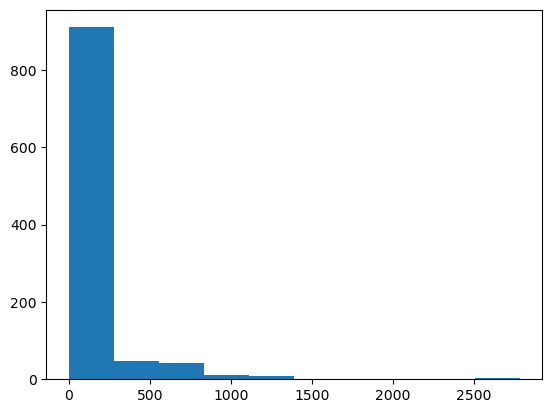

In [63]:
import matplotlib.pyplot as plt

plt.hist(df_not_during_disaster[df_not_during_disaster['ANONID'] == 42833]['MINUTES_DIFFERENCE'])

#### Concatenate all interclick times - not during disaster

Look at a histogram of this. Labels and title

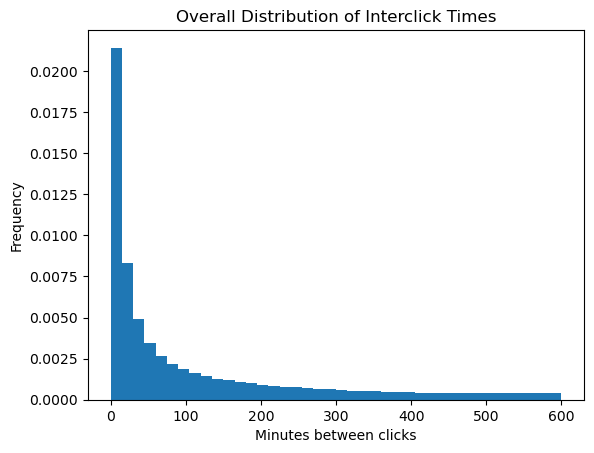

In [64]:
# Get rid of those interclick times that are 0 and those that are more than 10 hours
plotting_df = df_not_during_disaster[df_not_during_disaster['MINUTES_DIFFERENCE'] < 600]
plotting_df = plotting_df[plotting_df['MINUTES_DIFFERENCE'] > 0]['MINUTES_DIFFERENCE']

max_value = max(plotting_df)
bin_width = 15
bins = list(range(0, int(max_value) + bin_width, bin_width))
plt.hist(plotting_df, bins=bins, density=True)

plt.xlabel('Minutes between clicks')
plt.ylabel('Frequency')
plt.title('Overall Distribution of Interclick Times')
plt.show()


#### Find the rate parameter of the distribution - Equal to that of the poisson process.

In [65]:
rate = 1/plotting_df.mean()
print(rate)

rate_mins_during_disaster = 1/df_not_during_disaster[df_not_during_disaster['MINUTES_DIFFERENCE'] > 0]['MINUTES_DIFFERENCE'].mean()
print(rate)


0.008830374164159795
0.008830374164159795


#### Concatenate all interclick times - during disaster

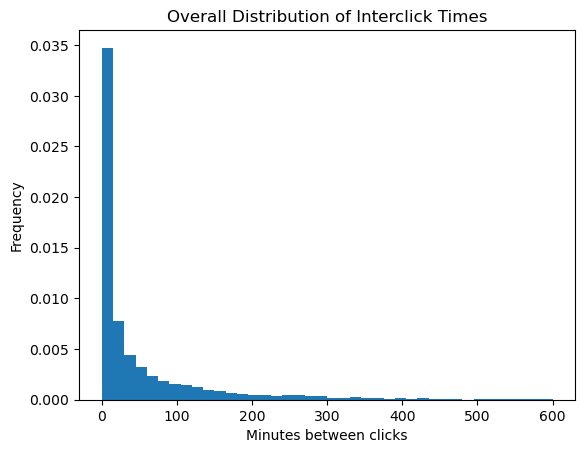

In [66]:
# Get rid of those interclick times that are 0 and those that are more than 10 hours
plotting_df = df_during_disaster[df_during_disaster['MINUTES_DIFFERENCE'] < 600]
plotting_df = plotting_df[plotting_df['MINUTES_DIFFERENCE'] > 0]['MINUTES_DIFFERENCE']

max_value = max(plotting_df)
bin_width = 15
bins = list(range(0, int(max_value) + bin_width, bin_width))
plt.hist(plotting_df, bins=bins, density=True)

plt.xlabel('Minutes between clicks')
plt.ylabel('Frequency')
plt.title('Overall Distribution of Interclick Times')
plt.show()

#### Find parameter estimate of distribution

In [67]:
rate = 1/plotting_df.mean()
print(rate)

rate_mins_during_disaster = 1/df_during_disaster[df_during_disaster['MINUTES_DIFFERENCE'] > 0]['MINUTES_DIFFERENCE'].mean()
print(rate)


0.01881562269662926
0.01881562269662926


#### Do the same thing with seconds - not during disaster

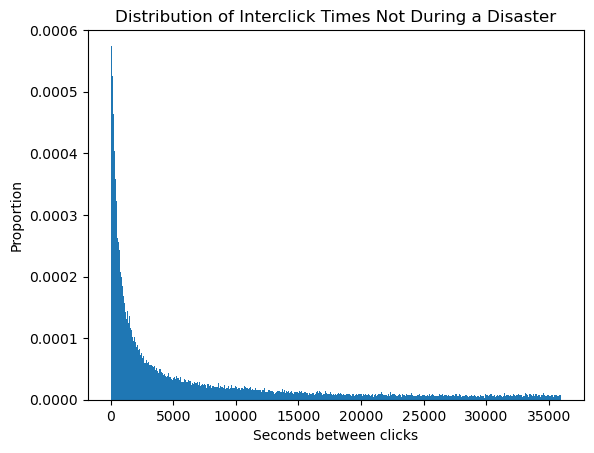

In [74]:
# Get rid of those interclick times that are 0 and those that are more than 10 hours
plotting_df = df_not_during_disaster[df_not_during_disaster['SECONDS_DIFFERENCE'] < 36000]
plotting_df = plotting_df[plotting_df['SECONDS_DIFFERENCE'] > 0]['SECONDS_DIFFERENCE']

max_value = max(plotting_df)
bin_width = 15
bins = list(range(0, int(max_value) + bin_width, bin_width))
plt.hist(plotting_df, bins=bins, density=True)
plt.ylim(top=0.0006)
plt.xlabel('Seconds between clicks')
plt.ylabel('Proportion')
plt.title('Distribution of Interclick Times Not During a Disaster')
plt.show()

In [69]:
rate = 1/plotting_df.mean()
print(rate)

rate_secs_not_during_disaster = 1/df_not_during_disaster[df_not_during_disaster['SECONDS_DIFFERENCE'] > 0]['SECONDS_DIFFERENCE'].mean()
print(rate)


0.0001471729027359966
0.0001471729027359966


#### Do the same thing with seconds - during disaster

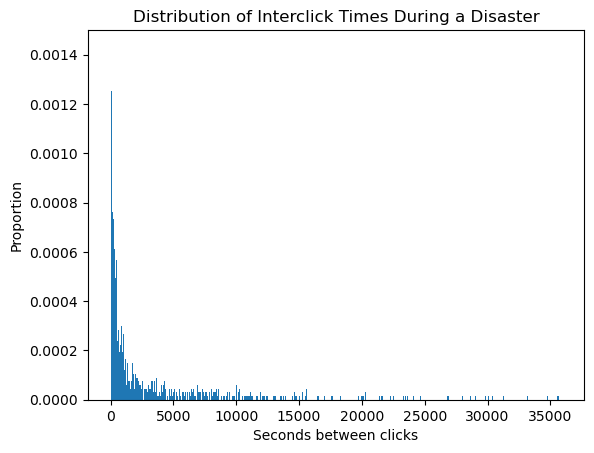

In [70]:
# Get rid of those interclick times that are 0 and those that are more than 10 hours
plotting_df = df_during_disaster[df_during_disaster['SECONDS_DIFFERENCE'] < 36000]
plotting_df = plotting_df[plotting_df['SECONDS_DIFFERENCE'] > 0]['SECONDS_DIFFERENCE']

max_value = max(plotting_df)
bin_width = 15
bins = list(range(0, int(max_value) + bin_width, bin_width))
plt.hist(plotting_df, bins=bins, density=True)
plt.ylim(top=0.0015)
plt.xlabel('Seconds between clicks')
plt.ylabel('Proportion')
plt.title('Distribution of Interclick Times During a Disaster')
plt.show()

In [71]:
rate = 1/plotting_df.mean()
print(rate)

rate_secs_not_during_disaster = 1/df_during_disaster[df_during_disaster['SECONDS_DIFFERENCE'] > 0]['SECONDS_DIFFERENCE'].mean()
print(rate)


0.0003135937116104877
0.0003135937116104877


## STATISTICAL TESTS

#### Is there a statistically significant difference between the interclick times occurring during a tornado and those occurring during a time period with no tornado?

T-Test assuming non-equal variance

Significance level: 0.05

H_0: There is no difference in mean interclick time between those occurring during and those not occurring during a natural disaster.

H_A: There is a difference in mean interclick time between those occurring during and those not occurring during a natural disaster.

In [72]:
import scipy

not_during_disaster = df_not_during_disaster[df_not_during_disaster['SECONDS_DIFFERENCE'] > 0]['SECONDS_DIFFERENCE']
during_disaster = df_during_disaster[df_during_disaster['SECONDS_DIFFERENCE'] > 0]['SECONDS_DIFFERENCE']

print(scipy.stats.ttest_ind(not_during_disaster, during_disaster, equal_var=False))

TtestResult(statistic=-44.54663771218602, pvalue=0.0, df=10163.71350089679)


Because the p-value is less than the significance level of 0.05, we reject the null hypothesis of: There is no difference in mean interclick time between those occurring during and those not occurring during a natural disaster. That is, the statistical evidence is consistent with the alternative hypothesis: There is a difference in mean interclick time between those occurring during and those not occurring during a natural disaster.